In [1]:
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from xbbg import blp as blp
import openpyxl

In [3]:
# xfile = openpyxl.load_workbook('Database.xlsx')

# sheet = xfile['Sheet1']
# sheet['A1'] = 'hello world'
# xfile.save('Database.xlsx')

In [4]:
addr_DBcoverage = r'C:\Users\chins\Documents\GitHub\Coding_Projects\Database_coverage.xlsx'
addr_db = r'C:\Users\chins\Documents\GitHub\Coding_Projects\Database.xlsx'

class bbg_api():
    
    def __init__(self,addr_DBcoverage,addr_db):
        self.index_tickers = pd.read_excel(addr_DBcoverage,'MSCI')
        self.database = pd.read_excel(addr_db)
        self.cty_index_data = pd.read_excel(addr_db,'Country Indices')
        self.pmi_tickers = pd.read_excel(addr_DBcoverage,'PMI')
        
    def check_data(self,data):
        return self.cty_index_data
    
        
#     def get_data(self,stocks,field, start, end):
#         df = blp.bdh(stocks, field,start, end)
#         time_period = pd.date_range(start,end)
#         output = df.reindex(time_period,method = 'bfill')
#         return(output)
    
    def get_data2(self,stocks,field, start, end, norm = False):
        if type(stocks) == type([]):
            lst_output = []
            for ticker in stocks:            
                df = blp.bdh(ticker, field,start, end)
                time_period = pd.date_range(start,end)
                output = df.reindex(time_period,method = 'bfill')            
                lst_output.append(df)
            output = pd.concat(lst_output,axis=1)   
        elif type(stocks) == type('str'):
            df = blp.bdh(stocks, field,start, end)
            time_period = pd.date_range(start,end)
            output = df.reindex(time_period,method = 'bfill')
            
        if norm == True:
            output = output / output.iloc[0]
        return(output)
    
    #Future work: Add in error msg with field suggestions.
    def plot_index(self,str_group,start,end,field = 'PX_LAST',norm = True):
        df = self.index_tickers[self.index_tickers['Group'] == str_group]
        lst_tickers = df['Ticker']
        lst_output = []
        for ticker in lst_tickers:            
            df = self.get_data2(ticker,field,start,end)
            lst_output.append(df)
        output = pd.concat(lst_output,axis=1)        
        if norm == True:
            output = output/output.iloc[0]
        output.columns = lst_tickers
        output.plot(grid=True)
        
    
        

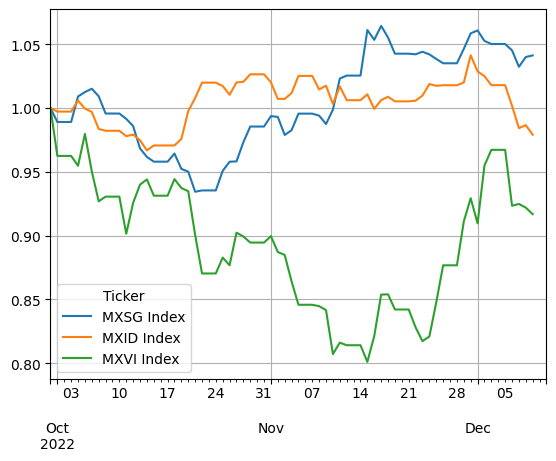

In [20]:
db = bbg_api(addr_DBcoverage,addr_db)
# print(db.index_tickers)
# db.get_data(['QQQ US EQUITY','MSFT US EQUITY','M7SGE Index'],'PX_LAST','20220101','20220220').tail()
db.plot_index('ASEAN','20220930','20221211',norm=True)
# db.get_data2('QQQ US EQUITY','PX_LAST','20220101','20220220')


<AxesSubplot: >

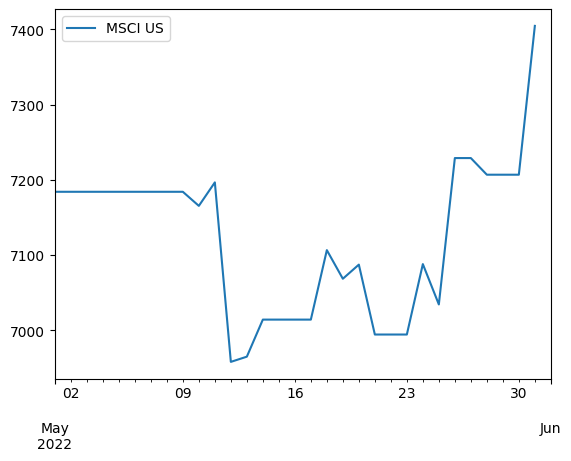

In [4]:
df = blp.bdh('MXID INDEX','PX_LAST','20220501','20220601')
time_period = pd.date_range('20220501','20220601')
output = df.reindex(time_period,method = 'bfill')

output.columns = ['MSCI US']
output.plot()

In [5]:
class yf_perf_analysis():
    
    
    def __init__(self,addr_weight):
        
        #Clean weights file
        self.weights = pd.read_excel(addr_weight)
        self.weights.set_index('Date',inplace=True)
        
        #Extract tickers into a list
        self.lst_tickers = self.weights.columns.values.tolist()
        
    def clean_weights(self,dt_start,dt_end):
        if dt_start < min(self.weights.index.strftime('%Y-%m-%d')):
            raise Exception('Start date before fund inception.')
        else:
            time_period = pd.date_range(dt_start,dt_end)        
            df_weight = self.weights.reindex(time_period,method='ffill')
        return df_weight
    
    def get_data(self,stocks, start, end, field):
        df = yf.download(stocks, start=start, end=end)
        time_period = pd.date_range(start,end)
        df = df.reindex(time_period,method = 'nearest')
        output = df[field]
        return(output)
    
    def cal_perf(self,dt_start,dt_end,str_field ='Adj Close'):
        df_weights = self.clean_weights(dt_start,dt_end)
        
        df_price = self.get_data(self.lst_tickers,dt_start,dt_end,str_field)
        df_period = df_price.loc[dt_start:dt_end,:]
        df_norm = df_period / df_period.iloc[0]
        df_total = df_norm * df_weights
        df_total['Total'] = df_total.sum(axis=1)
        return df_total

    #to prevent direct calling of weights and tickers
    @property
    def port_weights(self):
        return self.weights
    
    @property
    def port_tickers(self):
        return self.lst_tickers
    
    #Convert to plt? and change the line types for the sec and total.
    #Add subplot for benchmark vs total.
    def plot_perf(self,dt_start,dt_end):
        df = self.cal_perf(dt_start,dt_end)
        df = df / df.iloc[0,:]
        ax = df.plot(xlabel = 'Date',ylabel = '',
#                     subplots = True, layout = (5,-1), sharex=True #use -1 in col to auto calculate
                    )



    
        


[*********************100%***********************]  4 of 4 completed


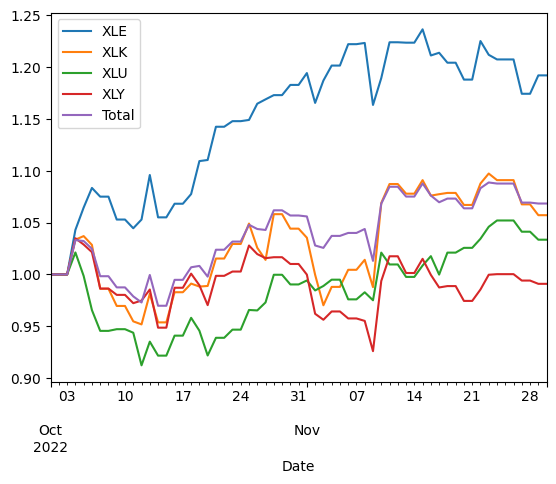

In [6]:
# addr_file = r'C:\Users\chins\Downloads\Finance_Test_File.xlsx'
addr_file = r'C:\Users\chins\Downloads\Sector Portfolio.xlsx'
perf = yf_perf_analysis(addr_file)
# perf.clean_weights('2022-01-01','2022-03-30').tail()
# perf.get_data('DJI','2022-01-01','2022-03-30','Adj Close')
# perf.cal_perf('2022-01-01','2022-01-30')
perf.plot_perf('2022-10-01','2022-11-30')

In [7]:
# perf.get_data('A17U.SI','2022-01-01','2022-03-30','Adj Close')

In [8]:
#         fig,ax  = plt.subplots()
#         ax.plot(df.index,df['Total'])
#         ax = fig.add_subplot(111)
# #         years = mdates.YearLocator()
# #         months = mdates.MonthLocator()
# #         yearsFmt = mdates.DateFormatter('%Y')
        
# #         # format the ticks
# #         ax.xaxis.set_major_locator(years)
# #         ax.xaxis.set_major_formatter(yearsFmt)
# #         ax.xaxis.set_minor_locator(months)
        
# #         # rotates and right aligns the x labels, and moves the bottom of the
# #         # axes up to make room for them
# #         fig.autofmt_xdate()
# #         plt.show()